<a href="https://colab.research.google.com/github/cwattsnogueira/rating-predictor-spam-detection-review-summarizer/blob/main/05_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering for Fake Review Detection

This notebook creates structured features from review metadata and cleaned text. I generate a binary target (`fake_review_label`) and prepare all inputs for ML and DL models.

In [2]:
import pandas as pd
import numpy as np
import joblib
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_parquet("/content/cleaned_reviews_with_text.parquet")
X_tfidf = joblib.load("/content/X_count_vectorized.pkl")
print("Data loaded:", df.shape)

Data loaded: (9480, 33)


In [4]:
df.columns

Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.username', 'upc', 'purchase_missing_flag', 'purchase_status',
       'purchase_encoded', 'recommend_missing_flag', 'recommend_status',
       'recommend_encoded', 'helpful_missing_flag', 'no_helpful_votes_flag',
       'log_helpful', 'main_category', 'category_group', 'clean_text',
       'text_length', 'is_short'],
      dtype='object')

## Sentiment Polarity

In [5]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment_polarity'] = df['clean_text'].apply(get_sentiment)

In [6]:
def polarity_bucket(score):
    if score > 0.3:
        return 'positive'
    elif score < -0.3:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['sentiment_polarity'].apply(polarity_bucket)

## Review Length


In [7]:
df['review_length'] = df['clean_text'].str.split().apply(len)

## Username Duplication Flag

In [8]:
# Count how many times each username appears
username_counts = df['reviews.username'].value_counts()

# Filter only usernames that appear more than once
duplicate_usernames = username_counts[username_counts > 1]

# Display result
print(f"Found {len(duplicate_usernames)} usernames with multiple reviews.")
display(duplicate_usernames.head(10))  # Show top 10

Found 287 usernames with multiple reviews.


,count
reviews.username,
Anonymous,60
An anonymous customer,48
Chris,14
Mike,9
John,7
Cindy,6
Missy,6
Angel,5
Alex,5


In [9]:
df['username_dup_flag'] = df['reviews.username'].isin(duplicate_usernames.index).astype(int)

In [10]:
# Flag: Same user, same date, same title
df['multi_review_same_day_flag'] = df.duplicated(subset=['reviews.username', 'reviews.date', 'reviews.title'], keep=False).astype(int)

# Flag: Same user reviewing same product multiple times
df['multi_review_same_product_flag'] = df.duplicated(subset=['upc', 'reviews.username'], keep=False).astype(int)

## Encode Categorical Features

In [11]:
le_brand = LabelEncoder()
df['brand_encoded'] = le_brand.fit_transform(df['brand'])

In [12]:
le_category_group = LabelEncoder()
df['category_group_encoded'] = le_category_group.fit_transform(df['category_group'])

## check if the review text matches the product name

In [13]:
import re

# Improved product name match: token overlap
def product_name_in_text(row):
    if pd.isna(row['clean_text']) or pd.isna(row['name']):
        return 0
    name_tokens = set(re.findall(r'\w+', row['name'].lower()))
    text_tokens = set(re.findall(r'\w+', row['clean_text'].lower()))
    return int(len(name_tokens.intersection(text_tokens)) > 0)

df['product_name_match_flag'] = df.apply(product_name_in_text, axis=1)

In [14]:
# Expanded keyword map for unrelated product detection
category_keywords = {
    'skincare': ['cream', 'moisturizer', 'moisturizers', 'soap', 'lotion', 'cleanser', 'cleansers'],
    'haircare': ['shampoo', 'conditioner', 'conditioners', 'hair'],
    'makeup': ['lipstick', 'foundation', 'concealer', 'bronzer', 'makeup'],
    'fragrance': ['perfume', 'scent', 'aroma', 'fragrance'],
    'bodycare': ['body wash', 'gel', 'lubricant', 'lotions'],
    'food': ['taste', 'sauce', 'cake', 'pizza', 'ketchup', 'flavor'],
    'household': ['detergent', 'cleaner', 'glass', 'soap', 'spray'],
    'home': ['lamp', 'bed', 'furniture', 'shelf', 'blanket'],
    'entertainment': ['movie', 'dvd', 'blu-ray', 'series', 'album'],
    'other': []
}

In [15]:
# Flag if unrelated keywords appear in the review
def unrelated_product_flag(row):
    text = row['clean_text'].lower() if pd.notna(row['clean_text']) else ''
    category = row['category_group']
    expected_keywords = category_keywords.get(category, [])

    for other_cat, keywords in category_keywords.items():
        if other_cat != category:
            for word in keywords:
                if word in text:
                    return 1
    return 0

df['unrelated_product_flag'] = df.apply(unrelated_product_flag, axis=1)

In [16]:
# semantic mismatch score
df['semantic_mismatch_score'] = (
    (df['product_name_match_flag'] == 0).astype(int) +
    df['unrelated_product_flag']
)

In [17]:
def repetition_score(text):
    tokens = text.lower().split()
    return max(pd.Series(tokens).value_counts(normalize=True).values) if tokens else 0

df['repetition_score'] = df['clean_text'].apply(repetition_score)

## Create Target: Fake Review Label

In [18]:
def generate_fake_review_label(row):
    short_extreme = (row['review_length'] < 5) and (abs(row['sentiment_polarity']) > 0.9)
    mismatch = row['semantic_mismatch_score'] > 0 and row['username_dup_flag'] == 1
    repetitive = row['repetition_score'] > 0.5
    return int(short_extreme or mismatch or repetitive)

df['fake_review_label'] = df.apply(generate_fake_review_label, axis=1)

## Select Structured Features

In [19]:
structured_features = [
    # Textual and behavioral
    'review_length', 'sentiment_polarity', 'repetition_score',

    # Engagement and helpfulness
    'log_helpful', 'no_helpful_votes_flag', 'helpful_missing_flag',

    # Purchase and recommendation signals
    'purchase_encoded', 'recommend_encoded',
    'purchase_missing_flag', 'recommend_missing_flag',

    # Metadata and semantic alignment
    'username_dup_flag', 'multi_review_same_day_flag', 'multi_review_same_product_flag',
    'product_name_match_flag',
    'unrelated_product_flag', 'semantic_mismatch_score',

    # Categorical encodings
    'brand_encoded', 'category_group_encoded'
]

X_structured = df[structured_features].values
y = df['fake_review_label'].values

In [20]:
print("\nFake review label distribution:")
print(df['fake_review_label'].value_counts())


Fake review label distribution:
fake_review_label
0    8800
1     680
Name: count, dtype: int64


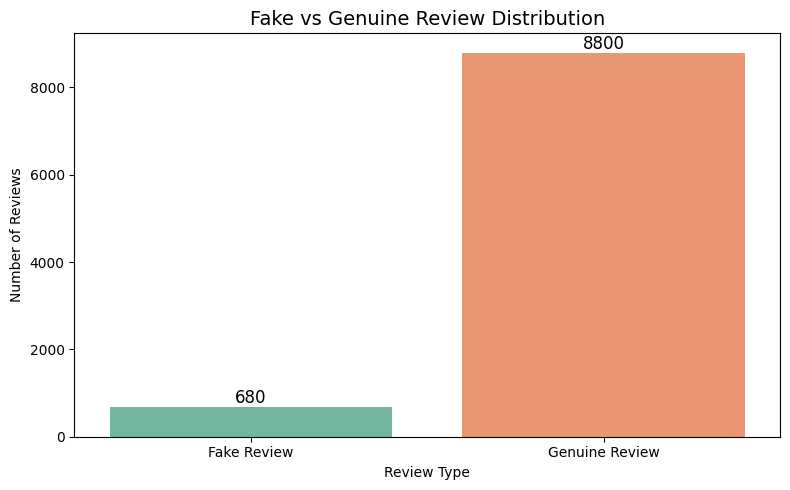

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

#
label_map = {0: 'Genuine Review', 1: 'Fake Review'}
df['label_text'] = df['fake_review_label'].map(label_map)

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label_text', data=df, hue='label_text', palette='Set2', legend=False)
plt.title("Fake vs Genuine Review Distribution", fontsize=14)
plt.xlabel("Review Type")
plt.ylabel("Number of Reviews")

#
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}',
                (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

## Save Outputs

In [22]:
np.save("/content/X_structured.npy", X_structured)
np.save("/content/y_fake_review.npy", y)
joblib.dump(structured_features, "/content/feature_names.json")

df.to_parquet("/content/engineered_features.parquet", index=False)
print("Saved all engineered features.")

Saved all engineered features.


In [23]:
joblib.dump(le_brand, "/content/label_encoder_brand.pkl")
joblib.dump(le_category_group, "/content/label_encoder_category_group.pkl")

['/content/label_encoder_category_group.pkl']

In [24]:
df[['fake_review_label']].to_parquet("/content/fake_review_labels.parquet", index=True)

## head(5) or unique()

In [25]:
df[['sentiment_polarity', 'review_length', 'username_dup_flag', 'brand_encoded', 'fake_review_label']].head()

,sentiment_polarity,review_length,username_dup_flag,brand_encoded,fake_review_label
0,0.133333,19,1,65,1
1,0.700000,6,1,33,1
2,0.700000,2,1,33,1
3,-0.007175,55,1,30,1
4,0.000000,14,0,30,0


In [26]:
df['sentiment_polarity'].head(5)

,sentiment_polarity
0,0.133333
1,0.700000
2,0.700000
3,-0.007175
4,0.000000


In [27]:
df['review_length'].head(5)

,review_length
0,19
1,6
2,2
3,55
4,14


In [28]:
df['username_dup_flag'].head(5)

,username_dup_flag
0,1
1,1
2,1
3,1
4,0


In [29]:
df['brand_encoded'].head(5)

,brand_encoded
0,65
1,33
2,33
3,30
4,30


In [30]:
df['fake_review_label'].head(5)

,fake_review_label
0,1
1,1
2,1
3,1
4,0


## Features

In [31]:
feature_descriptions = {
    'review_length': 'Number of tokens in the cleaned review text',
    'sentiment_polarity': 'Polarity score from TextBlob (-1 to +1)',
    'repetition_score': 'Max normalized frequency of repeated tokens',
    'log_helpful': 'Log-transformed helpful vote count',
    'no_helpful_votes_flag': 'Binary flag for zero helpful votes',
    'helpful_missing_flag': 'Binary flag for missing helpful vote field',
    'purchase_encoded': 'Ordinal encoding of purchase status',
    'recommend_encoded': 'Ordinal encoding of recommendation status',
    'purchase_missing_flag': 'Binary flag for missing purchase info',
    'recommend_missing_flag': 'Binary flag for missing recommendation info',
    'username_dup_flag': 'User appears more than once in dataset',
    'multi_review_same_day_flag': 'Same user reviewed multiple items on same day with same title',
    'multi_review_same_product_flag': 'Same user reviewed same product multiple times',
    'product_name_match_flag': 'Review text overlaps with product name',
    'unrelated_product_flag': 'Review contains keywords from unrelated categories',
    'semantic_mismatch_score': 'Sum of product name mismatch and unrelated keyword flag',
    'brand_encoded': 'Label-encoded brand name',
    'category_group_encoded': 'Label-encoded product category group'
}

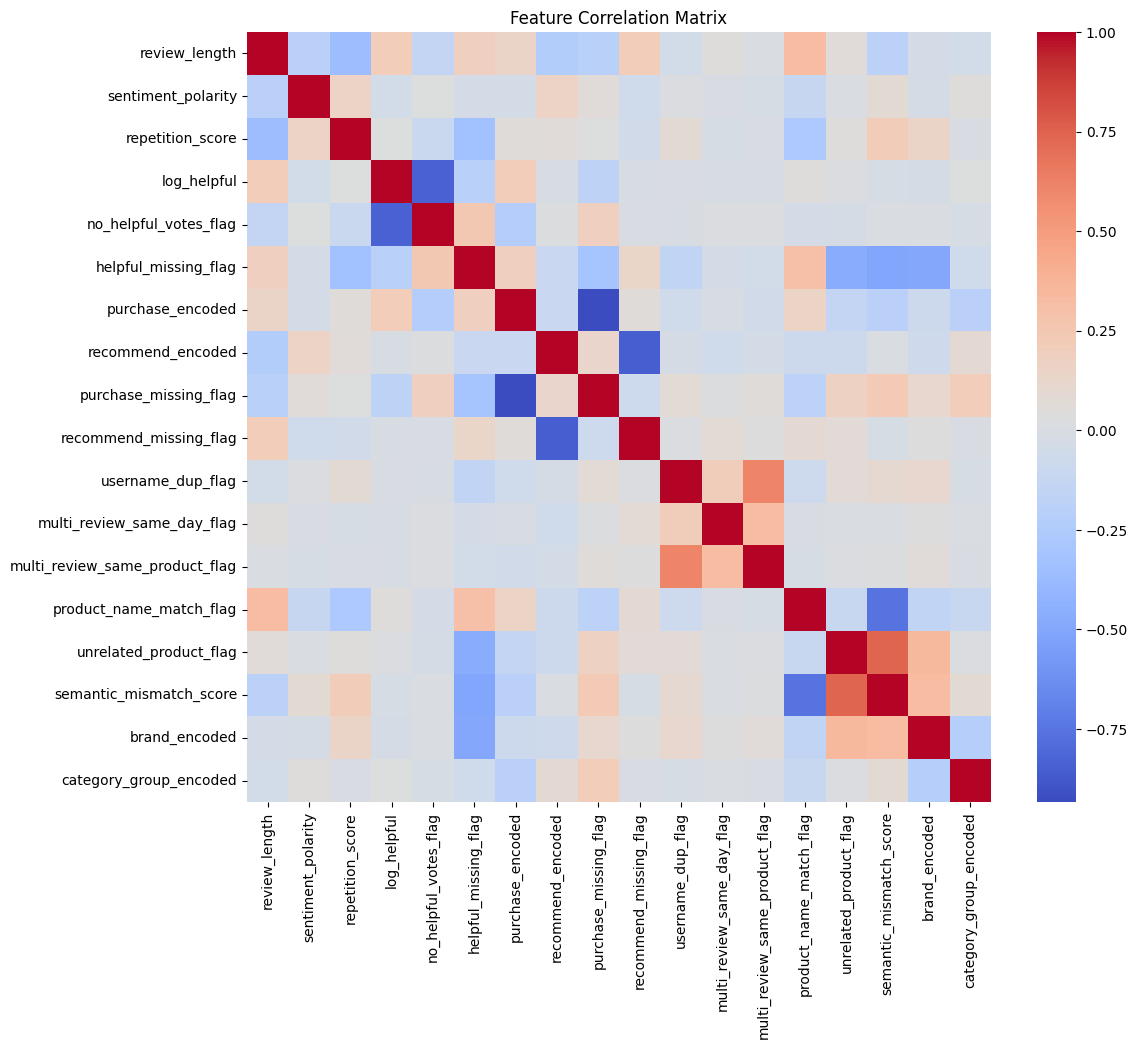

In [32]:
import seaborn as sns
corr = df[structured_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()